<a href="https://colab.research.google.com/github/BrunoGeraldine/B3_Prediction_2023/blob/main/notebook/B3_LTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# B3_Prediction_2023 → LTSM

## Bibliotecas e help functions

In [2]:
# Import
import sidetable
import numpy                 as np
import pandas                as pd
import seaborn               as sns
import matplotlib.pyplot     as plt

from tensorflow.keras.models import Sequential
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [3]:
## Help Functions

# Supress scientific Notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Read data

In [4]:
df = pd.read_parquet('/home/bruno/repos/B3_Prediction_2023/dataset/all_bovespa_18_23.parquet')

In [5]:
df.head()

,data_pregao,sigla_acao,nome_acao,preco_abert,preco_max,preco_min,preco_fech,qtd_negocios,vol_negocios
0,2018-01-02,AALR3,ALLIAR,14.94,15.16,14.70,14.89,94500.00,140299100.00
1,2018-01-02,AAPL34,APPLE,56.81,56.81,56.30,56.30,900.00,5074700.00
2,2018-01-02,ABCB4,ABC BRASIL,16.83,16.85,16.56,16.58,326300.00,543316000.00
3,2018-01-02,ABEV3,AMBEV S/A,21.33,21.75,21.17,21.69,12717900.00,27481342800.00
4,2018-01-02,ADHM3,ADVANCED-DH,2.00,2.00,1.98,1.99,4600.00,917600.00


# Action_Filter

In [6]:
df_acao = df.copy()

In [7]:
sigla = 'PETR4'
df_acao = df[df['sigla_acao'] == sigla ]

In [8]:
df_acao

,data_pregao,sigla_acao,nome_acao,preco_abert,preco_max,preco_min,preco_fech,qtd_negocios,vol_negocios
229,2018-01-02,PETR4,PETROBRAS,16.19,16.55,16.19,16.55,33461800.00,54962814900.00
595,2018-01-03,PETR4,PETROBRAS,16.49,16.72,16.37,16.70,55940900.00,92761001600.00
1002,2018-01-04,PETR4,PETROBRAS,16.78,16.96,16.62,16.73,37064900.00,62409986400.00
1407,2018-01-05,PETR4,PETROBRAS,16.70,16.86,16.57,16.83,26958200.00,45200759800.00
1805,2018-01-08,PETR4,PETROBRAS,16.74,17.03,16.71,17.03,28400000.00,48057591400.00
...,...,...,...,...,...,...,...,...,...
524526,2023-04-28,PETR4,PETROBRAS,23.60,24.05,23.15,23.70,81138500.00,191864713300.00
524681,2023-05-02,PETR4,PETROBRAS,23.70,23.74,22.64,22.74,67911100.00,155726474500.00
524975,2023-05-03,PETR4,PETROBRAS,22.60,22.99,22.42,22.66,51133700.00,116212793500.00
525545,2023-05-04,PETR4,PETROBRAS,22.89,23.38,22.61,23.02,57854400.00,133065093100.00


In [9]:
# Selecionando os campos que vamos análisar
df_acao_fech = df_acao[['data_pregao', 'preco_fech']]


In [10]:
# Ajustando o indice pela data
df_acao_fech = df_acao_fech.set_index(pd.DatetimeIndex(df_acao_fech['data_pregao'].values))

In [11]:
# Eliminano a coluna 'data_pregao'

df_acao_fech.drop(columns=['data_pregao'], inplace=True)

# EDA → Action

## Verificar quantidade de linhas

In [12]:
print( f'Number of Rows: {df_acao_fech.shape[0]}' )
print( f'Number of Columns: {df_acao_fech.shape[1]}' ) 

Number of Rows: 1074
Number of Columns: 1


## Data types

In [19]:
df_acao_fech.dtypes

preco_fech    float64
dtype: object

In [13]:
df_acao.dtypes

data_pregao     datetime64[ns]
sigla_acao              object
nome_acao               object
preco_abert            float64
preco_max              float64
preco_min              float64
preco_fech             float64
qtd_negocios           float64
vol_negocios           float64
dtype: object

## Check NA

In [14]:
df_acao_fech.stb.missing()

,missing,total,percent
preco_fech,0,1074,0.00


## Data description

In [15]:
df_acao_fech.describe()

,preco_fech
count,1074.00
mean,24.41
std,4.01
min,11.29
25%,21.68
50%,25.45
75%,27.45
max,31.12


## Grafico dos valores de fechamento

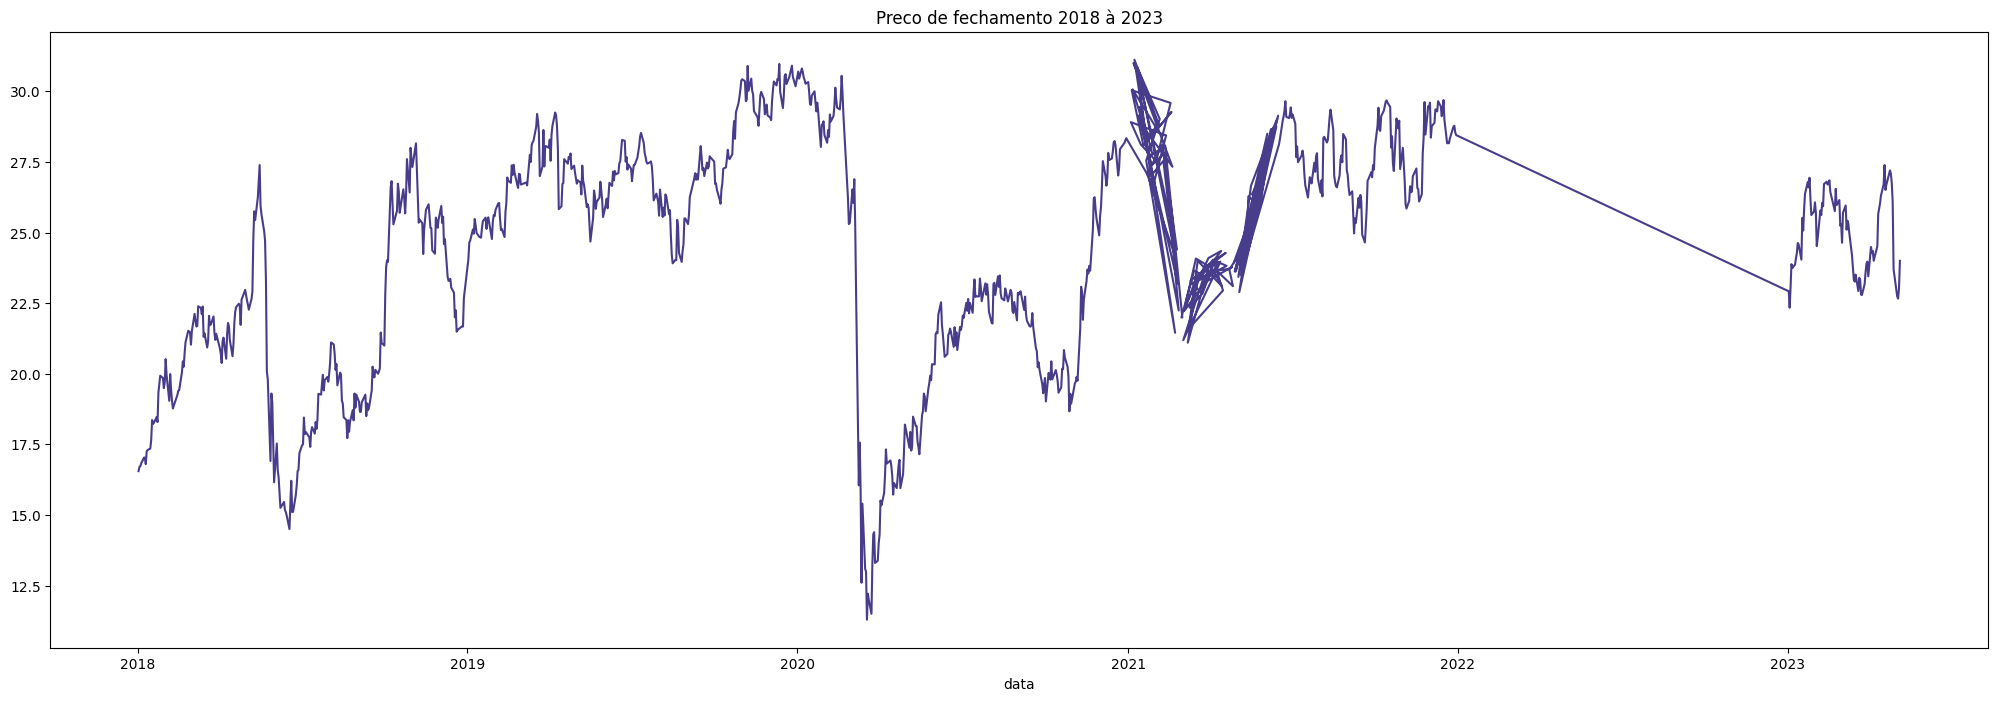

In [16]:
# Plotando o comportamento da ação ao longo do periodo 2019 > 2023

plt.figure(figsize=(25,8))
plt.title('Preco de fechamento 2018 à 2023')
plt.plot(df_acao_fech['preco_fech'], color='darkslateblue' )
plt.xlabel('data');


# Train_Test_Split

In [17]:
# coletando a quantidade de linhas
qtd_linhas = len(df_acao_fech)

qtd_linhas_treino =round(.70 * qtd_linhas)

qtd_linhas_test = qtd_linhas - qtd_linhas_treino

info = (
    f'Linhas de treino = 0:{qtd_linhas_treino}, '
    f'linhas de teste = {qtd_linhas_treino}:{qtd_linhas_treino+qtd_linhas_test}'
)

info

'Linhas de treino = 0:752, linhas de teste = 752:1074'

# Data Modeling

In [18]:
# Normalização dos dados

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_acao_fech)

## Select Train_data and Test_data

In [19]:
train = df_scaled[:qtd_linhas_treino]
test = df_scaled[qtd_linhas_treino:qtd_linhas_treino+qtd_linhas_test]

print(len(train), len(test))

752 322


In [20]:
# Função que trasnforma os dados no tipo de dados que o LTSM requisita para o funcionamento
def creat_df(df, steps=1):
  dataX, dataY = [], []
  for i in range(len(df)-steps-1):
    a = df[i:(i+steps), 0]
    dataX.append(a)
    dataY.append(df[i + steps, 0])
  
  return np.array(dataX), np.array(dataY)

""" Formata os valores que a rede LSTM espera """

' Formata os valores que a rede LSTM espera '

In [21]:
# Gerando os dados de treino e test
steps = 15 #(dias a prever)
X_train, Y_train = creat_df(train, steps)
X_test, Y_test = creat_df(test, steps)


In [22]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(736, 15)
(736,)
(306, 15)
(306,)


In [23]:
# Gerando os dados que o modelo espera

# O numero 1 no final do codigo refere-se a quantidade de features explicativos que o estamos passando
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [25]:
# Montando a rede LSTM
model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(steps, 1)))
# return_sequences=True → retorna a informação selecionada acima e reaplica o modelo 
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0.2)) #→ organiza as features para evitar overfit
model.add(Dense(1)) #→saida do modelo, no caso 1 (unica feature preco) "resposta preco previsto"

2023-05-08 16:11:37.757725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 16:11:37.759094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 16:11:37.760412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [26]:
# Compilando os dados da saida
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 15, 35)            5180      
                                                                 
 lstm_4 (LSTM)               (None, 15, 35)            9940      
                                                                 
 lstm_5 (LSTM)               (None, 35)                9940      
                                                                 
 dropout_1 (Dropout)         (None, 35)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 36        
                                                                 
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Treinamento do Modelo
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=15, verbose=2);

Epoch 1/100


2023-05-08 16:11:42.906568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 16:11:42.909329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 16:11:42.911494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
# grafico do comportamento do modelo
plt.figure(figsize=(20,8))
plt.plot(validation.history['loss'], label='Training loss')
plt.plot(validation.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
# Fazendo a previsão
prev = model.predict(X_test)
prev = scaler.inverse_transform(prev)
prev

In [ ]:
# Prevendo os proximos 10 dias
lenght_test = len(test)
lenght_test

In [ ]:
# Pegar os ultimos dias que são o tamanho do steps declarado anteriormente
days_input_steps = lenght_test - steps
days_input_steps

In [ ]:
#Transforma em array
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1, -1)
input_steps

In [ ]:
# Transfoprmar um lista
list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

In [ ]:
# Loop para prever os proximos 10 dias
#Loop to preview the next 10 days
pred_output = [] #→ recebe os dias a serem previstos
i = 0
n_future = 10
while(i<n_future):
  
    if(len(list_output_steps) > steps):
       input_steps = np.array(list_output_steps[1:])
       print('Day {}. Value Entrance → {}'.format(i, input_steps))
       input_steps = input_steps.reshape(1, -1)
       input_steps = input_steps.reshape((1, steps, 1))
       #print(input_steps)
       pred = model.predict(input_steps, verbose=0)
       print('Day {}. Value Predict → {}'.format(i, pred))
       list_output_steps.extend(pred[0].tolist())
       list_output_steps = list_output_steps[1:]
       #print(list_output_steps)
       pred_output.extend(pred.tolist())
       i = i+1
       
    else:
       input_steps = input_steps.reshape((1, steps, 1))
       pred= model.predict(input_steps, verbose=0)
       print(pred[0])
       list_output_steps.extend(pred[0].tolist())
       print(len(list_output_steps))
       pred_output.extend(pred.tolist())
       i = i+1
       
print(pred_output)
       
       


In [ ]:
# transformando o output  para lermos 
prev = scaler.inverse_transform(pred_output)
prev = np.array(prev).reshape(1,-1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev



In [ ]:
# Colhendo as datas de previsão
dates = pd.to_datetime(df_acao['data_pregao'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods=10, freq='b').tolist()
predict_dates


In [ ]:
# Criando o DataFrame de previsão
forecast_dates = []
for i in predict_dates:
  forecast_dates.append(i.date())

df_forecast = pd.DataFrame({'data_pregao': np.array(forecast_dates), 'preco_fechamento': list_output_prev})
df_forecast['data_pregao'] = pd.to_datetime(df_forecast['data_pregao'])

# transformando o index pela data
df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['data_pregao'].values))
df_forecast.drop(columns='data_pregao', inplace=True)
df_forecast

In [ ]:
# Filtrando apenas os dias utilizados para previsão
df_acao = df[(df['sigla_acao'] == sigla) & (df['data_pregao'] > '2023-04-01') ]
df_acao_fech = df_acao[['data_pregao', 'preco_fech']]
df_acao_fech = df_acao_fech.set_index(pd.DatetimeIndex(df_acao_fech['data_pregao'].values))
df_acao_fech.drop(columns='data_pregao', inplace=True)

In [ ]:
#Plotar o grafico
plt.figure(figsize=(16,8))
plt.title('Price Share Value')
plt.plot(df_acao_fech['preco_fech'])
plt.plot(df_forecast['preco_fechamento'])
plt.legend(['Price Closed', 'Price Predicted'])
plt.show();

In [ ]:
# Fazer um novo ciclo acrescentando o ano de 2018